In [1]:
import pandas as pd
import os
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

#### Load data

In [2]:
def load_result(filename):
    """Load a single result file."""
    with open(filename, 'r') as file:
        return json.load(file)

timestamp = "2025-06-20_15:08"

unseen_datapoints_df = pd.read_csv("files/unseen_transcripts.csv", index_col=0)

## load ground truths
groundtruth_df = pd.read_csv("files/clean_groundtruth.csv", index_col="stimulus_id")
groundtruth_df.columns = [col.replace('_cues', '') for col in groundtruth_df.columns]
music_groundtruth_df = pd.read_csv("music/music_binary_groundtruth.csv", index_col="stimulus_id")

themes = [
 'domesticity_nurturing',
 'fashion_beauty',
 'love_tenderness',
 'nature_animals',
 #'arts_crafts',
 'magic_fantasy',
 #'horror_monsters',
 #'action_adventure',
 'speed_racing',
 'fight_combat',
]

themes_shortened = [
 'domest./nurtu.',
 'fashion/beauty',
 'love/tender.',
 'nature/animals',
 #'arts/crafts',
 'magic/fantasy',
 #'horror/monst.',
 #'action/adve.',
 'speed/racing',
 'fight/combat',
]

emotions = [
    'Happy', 
    'Beauty', 
    'Calm', 
    'Angry',
]

mid_levels = [
  'Harmonious/Disharmonious',
  'High pitch/Low pitch',
  'Strong beat/Weak beat',
  'Punchy/Smooth',
  'Electric/Acoustic',
  'Loud/Soft',
  'Distorted/Clear',
  'Heavy/Light',
  'Dense/Sparse',
]

shortened_mid_levels = [
    'Harm./Dish.',
    'High/Low p.',
    'Str./Weak b.',
    'Punc./Smoo.',
    'Elec./Acou.',
    'Loud/Soft',
    'Dist./Clear',
    'Heavy/Light',
    'Dns./Sparse'
]

In [3]:
rows = []
for stimulus_id in unseen_datapoints_df.index.tolist():
    filename = f"results/{timestamp}/{stimulus_id}_target_classification.json"
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        continue
    llm_result = load_result(filename)
    music_pred = load_result(f"results/complete_binary_music_predictions/{stimulus_id}_music_pred.json")

    row = {
        "stimulus_id": stimulus_id,
        "target_of_toy_ad": llm_result['target_class'],
    }

    for theme in themes:
        row[theme] = llm_result['collected_cues'][theme]['cues']
    for emotion in emotions:
        row[emotion] = music_pred['emo'][emotion]
    for mid_level in mid_levels:
        row[mid_level] = music_pred['mid'][mid_level]

    rows.append(row)

predictions_df = pd.DataFrame(rows).set_index("stimulus_id")

predictions_df = predictions_df.merge(
    unseen_datapoints_df,
    left_index=True,
    right_index=True,
    how='left',
)

In [4]:
"Number of computationally analyzed commmercials:", len(predictions_df)

('Number of computationally analyzed commmercials:', 2041)

In [5]:
# Merge groundtruth_df with music_groundtruth_df
groundtruth_df = groundtruth_df.join(music_groundtruth_df, how="left", rsuffix="_duplicate")

# keep only useful cols
cols = [col for col in groundtruth_df.columns if col in predictions_df.columns]
groundtruth_df = groundtruth_df[cols]

In [6]:
# check quality of annotations
for theme in themes:
    temp_bool = predictions_df[theme].apply(
            lambda x: True if x else False # convert empty lists and Nans to False
        )
    temp_df = predictions_df[temp_bool].sample(10)
    print(f"{theme.upper()}:")
    print(predictions_df.loc[temp_df.index, [theme,"transcript"]].to_string(index=True))
    print("\n")

DOMESTICITY_NURTURING:
                                                                                                                           domesticity_nurturing                                                                                                                                                                                                                                                                                                                                                                                                                                                     transcript
stimulus_id                                                                                                                                                                                                                                                                                                                                                                                      

In [7]:
# concatenate predictions_df and groundtruth_df
hybrid_df = pd.concat([predictions_df, groundtruth_df], axis=0, ignore_index=False)

for theme in themes:
    hybrid_df[theme] = hybrid_df[theme].apply(
        lambda x: True if x else False # convert empty lists and Nans to False
    )

##### Now use the hybrid dataframe (with synthetic and real data) to find time trends in the commercials

In [8]:
hybrid_df.loc[hybrid_df.target_of_toy_ad=="Girls/women", "target_of_toy_ad"] = "Feminine"
hybrid_df.loc[hybrid_df.target_of_toy_ad=="Boys/men", "target_of_toy_ad"] = "Masculine"
print(hybrid_df.target_of_toy_ad.value_counts())
all_targets = hybrid_df.target_of_toy_ad.copy()

target_of_toy_ad
Mixed        902
Feminine     839
Masculine    767
Name: count, dtype: int64


In [9]:
#sns.set_theme(style="darkgrid")
sns.set(font_scale = 1.3)
colors = sns.color_palette("colorblind")

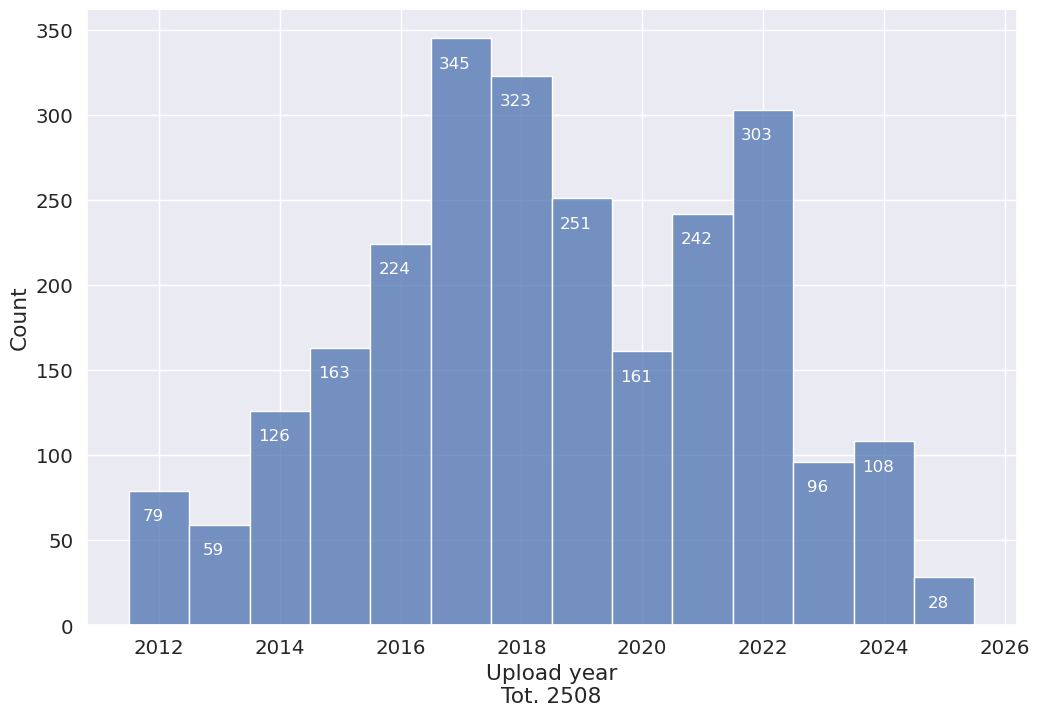

In [10]:
upload_years = hybrid_df["upload_date"].sort_values().astype("str").str[:4]
upload_years = upload_years.rename(f"Upload year\nTot. {hybrid_df.loc[all_targets.index].shape[0]}")
upload_years = upload_years.astype(int)

plt.figure(figsize=(12,8))
ax = sns.histplot(x=upload_years, discrete=True)
for p in ax.patches:
    annotation = p.get_height() if p.get_height()>10 else ""
    ax.annotate(f'\n{annotation}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=12)
#plt.savefig("upload_years.pdf", bbox_inches="tight")
plt.show()

#### Bin years 2 by 2 (or not)

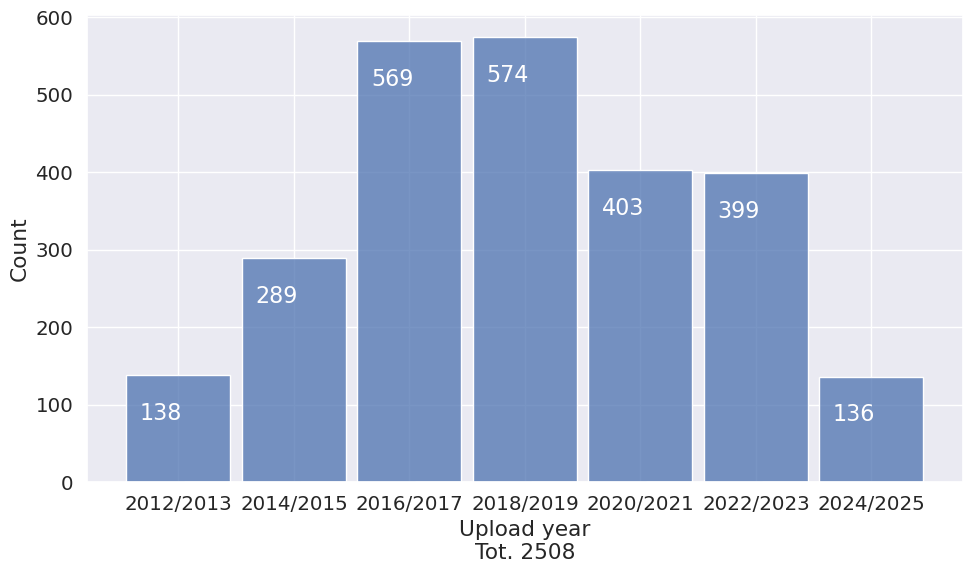

In [11]:
#_ = """
upload_years = upload_years.apply(
    lambda x: x-1 if ((x-1) % 2) == 0 else x
)
plt.figure(figsize=(10,6))
ax = sns.histplot(x=upload_years, discrete=True, shrink=1.8, fill=True)
for p in ax.patches:
    annotation = p.get_height() if p.get_height()>10 else ""
    ax.annotate(f'\n{annotation}', (p.get_x()+0.6, p.get_height()), ha='center', va='top', color='white', size=16)
plt.xticks(
    upload_years.unique(),
    upload_years.apply(lambda x : f"{x}/{x+1}").unique().tolist()
)
plt.tight_layout()
plt.savefig("upload_years_binned.pdf", bbox_inches="tight")
plt.show()
#"""



#### Define rho min treshold and the minimum count of commercials per bin

In [12]:
treshold = 0.6
minimum_count_per_year = 20

#### Emotions time-trend analysis across targets

In [13]:
emotions_df = hybrid_df[emotions].copy()

# convert values in emotions_df to float
emotions_df = emotions_df.replace({"low": 0, "high": 1}).astype(float)

#emotions_df = emotions_df.replace({"not": 0, "moderately": 1, "very": 2}).astype(float)
temp = emotions_df.join(upload_years.rename(f"Upload year")).groupby("Upload year").mean()

# drop years with less than minimum_count_per_year commercials
drop_these_years = upload_years.value_counts()[
    upload_years.value_counts() < minimum_count_per_year
].index.to_list()
temp = temp[~temp.index.isin(drop_these_years)]

temp_corr = []
for column in temp.columns:
    res = spearmanr(temp[column], temp.index)
    temp_corr.append({
        "rho": res.correlation,
        "p": res.pvalue,
        "column": column
    })

temp_corr = pd.DataFrame(temp_corr)
fields_with_correlation  = temp_corr[(temp_corr.p < 0.05) & (temp_corr.rho.abs() > treshold)]["column"]

dfm = temp[fields_with_correlation].reset_index().melt(
    "Upload year", 
    var_name='Scale (binned to binary)', 
    value_name="Ratio of positive predictions"
)

try:
    plt.figure(figsize=(8.75,5))
    g = sns.pointplot(x="Upload year", y="Ratio of positive predictions", hue='Scale (binned to binary)', data=dfm)#, kind='point')
    g.set(xlabel="Upload year", ylabel="Ratio of positive predictions", ylim=(0,1))
    plt.show()
except Exception as e:
    print(f"There is no correlation to plot.")

temp_corr[(temp_corr.p < 0.05) & (temp_corr.rho.abs() > treshold)].sort_values("p", ascending=True)

There is no correlation to plot.


,rho,p,column


<Figure size 875x500 with 0 Axes>

#### Mid-level descriptors time-trend analysis across targets

In [14]:
mid_level_df = hybrid_df[mid_levels].copy()
# convert values in mid_level_df to int
for col in mid_level_df.columns:
    replace_dict = {
        col.split("/")[0]: 0,
        col.split("/")[1]: 1
    }
    mid_level_df.loc[:,col] = mid_level_df[col].replace(replace_dict).astype(float)
temp = mid_level_df.join(upload_years.rename(f"Upload year")).groupby("Upload year").mean()

# drop years with less than minimum_count_per_year commercials
drop_these_years = upload_years.value_counts()[
    upload_years.value_counts() < minimum_count_per_year
].index.to_list()
temp = temp[~temp.index.isin(drop_these_years)]

temp_corr = []
for column in temp.columns:
    res = spearmanr(temp[column], temp.index)
    temp_corr.append({
        "rho": res.correlation,
        "p": res.pvalue,
        "column": column
    })

temp_corr = pd.DataFrame(temp_corr)
fields_with_correlation  = temp_corr[(temp_corr.p < 0.05) & (temp_corr.rho.abs() > treshold)]["column"]


dfm = temp[fields_with_correlation].reset_index().melt(
    "Upload year", 
    var_name='Scale (binned to binary)', 
    value_name="Ratio of positive predictions"
)

try:
    plt.figure(figsize=(8.75,5))
    g = sns.pointplot(x="Upload year", y="Ratio of positive predictions", hue='Scale (binned to binary)', data=dfm)#, kind='point')
    g.set(xlabel=None, ylabel=None, ylim=(0,1))
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"There is no correlation to plot.")

temp_corr[(temp_corr.p < 0.05) & (temp_corr.rho.abs() > treshold)].sort_values("p", ascending=True)

There is no correlation to plot.


,rho,p,column


<Figure size 875x500 with 0 Axes>

In [15]:
temp_corr[(temp_corr.p < 0.05)]

,rho,p,column


#### Themes time-series analysis across targets

In [16]:
themes_df = hybrid_df[themes].copy()

temp = themes_df.join(upload_years.rename(f"Upload year")).groupby("Upload year").mean()

# drop years with less than minimum_count_per_year commercials
drop_these_years = upload_years.value_counts()[
    upload_years.value_counts() < minimum_count_per_year
].index.to_list()

temp = temp[~temp.index.isin(drop_these_years)]

temp_corr = []
for column in temp.columns:
    res = spearmanr(temp[column], temp.index)
    temp_corr.append({
        "rho": res.correlation,
        "p": res.pvalue,
        "column": column
    })

temp_corr = pd.DataFrame(temp_corr)
fields_with_correlation  = temp_corr[(temp_corr.p < 0.05) & (temp_corr.rho.abs() > treshold)]["column"]
dfm = temp[fields_with_correlation].reset_index().melt(
    "Upload year", 
    var_name='Ratio', 
    value_name="Ratio of positive predictions"
)

if fields_with_correlation.to_list():
    plt.figure(figsize=(8.75,5))
    g = sns.pointplot(x="Upload year", y="Ratio of positive predictions", hue='Ratio', data=dfm)#, kind='point')
    g.set(xlabel=None, ylabel=None, ylim=(0,1))
    g.set_title(f"Classified as {target}")
    plt.tight_layout()
    plt.show()

temp_corr[(temp_corr.p < 0.05) & (temp_corr.rho.abs() > treshold)].sort_values("p", ascending=True)

,rho,p,column


In [17]:
temp_corr[(temp_corr.p < 0.05)]

,rho,p,column


#### Target-wise themes time-trend analysis

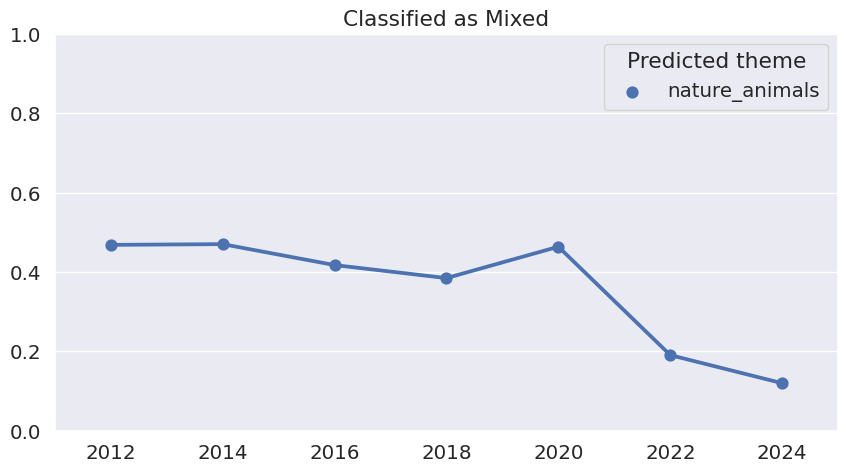

Delta: 34.88%


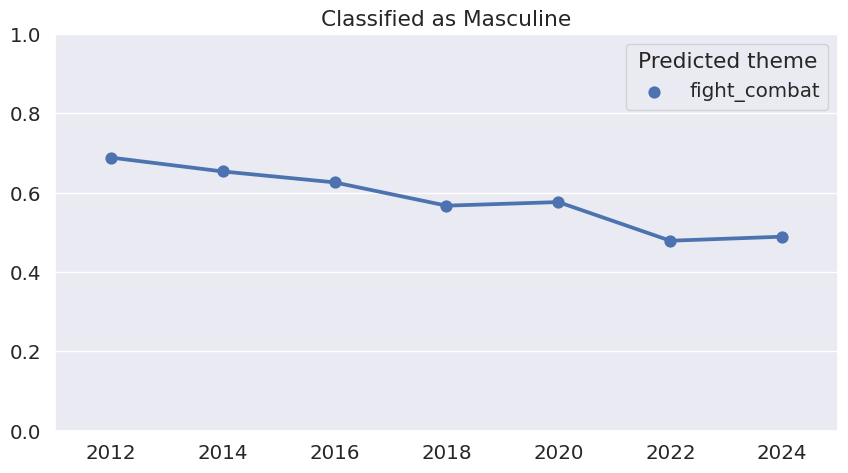

Delta: 19.95%


,rho,p,column
target,,,
Masculine,-0.928571,0.002519,fight_combat
Mixed,-0.857143,0.013697,nature_animals


In [18]:
rows = []
for i, target in enumerate(all_targets.unique()):
    temp_corr = []
    target_commercials = all_targets[all_targets==target].index
    target_years = upload_years[target_commercials].copy()
    target_years = target_years.rename(f"Upload year").sort_values()

    target_commercials_df = hybrid_df.loc[target_commercials].copy()
    themes_df = target_commercials_df[themes].copy()

    temp = themes_df.join(target_years).groupby("Upload year").mean()
    
    # drop years with less than minimum_count_per_year commercials
    drop_these_years = target_years.value_counts()[
        target_years.value_counts() < minimum_count_per_year
    ].index.to_list()
    
    temp = temp[~temp.index.isin(drop_these_years)]

    for column in temp.columns:
        res = spearmanr(temp[column], temp.index)
        rows.append({
            "target": target,
            "rho": res.correlation,
            "p": res.pvalue,
            "column": column
        })
        temp_corr.append(rows[-1])

    temp_corr = pd.DataFrame(temp_corr)
    fields_with_correlation  = temp_corr[(temp_corr.p < 0.05) & (temp_corr.rho.abs() > treshold)]["column"]
    dfm = temp[fields_with_correlation].reset_index().melt(
        "Upload year", 
        var_name='Predicted theme', 
        value_name="Ratio of positive predictions"
    )

    if fields_with_correlation.to_list():
        plt.figure(figsize=(8.75,5))
        g = sns.pointplot(x="Upload year", y="Ratio of positive predictions", hue='Predicted theme', data=dfm)#, kind='point')
        g.set(xlabel=None, ylabel=None, ylim=(0,1))
        g.set_title(f"Classified as {target}")
        plt.tight_layout()
        plt.show()
        delta = dfm.loc[0]["Ratio of positive predictions"] - dfm.loc[dfm.shape[0]-1]["Ratio of positive predictions"]
        print(f"Delta: {100*delta:.2f}%")

results_df = pd.DataFrame(rows).set_index("target")
results_df[results_df.p < 0.05].sort_values("p", ascending=True)

#### Target-wise emotions time-trend analysis

In [19]:
rows = []
for i, target in enumerate(["Girls/women","Mixed","Boys/men"]):

    temp_corr = []
    target_commercials = all_targets[all_targets==target].index
    target_years = upload_years[target_commercials].copy()
    target_years = target_years.rename(f"Upload year").sort_values()
    target_commercials_df = hybrid_df.loc[target_commercials].copy()
    emotions_df = target_commercials_df[emotions]

    # convert values in emotions_df to int
    emotions_df = emotions_df.replace({"low": 0, "high": 1}).astype(float)

    temp = emotions_df.join(target_years).groupby("Upload year").mean()

    # drop years with less than minimum_count_per_year commercials
    drop_these_years = target_years.value_counts()[
        target_years.value_counts() < minimum_count_per_year
    ].index.to_list()
    temp = temp[~temp.index.isin(drop_these_years)]

    for column in temp.columns:
        res = spearmanr(temp[column], temp.index)
        rows.append({
            "target": target,
            "rho": res.correlation,
            "p": res.pvalue,
            "column": column
        })
        temp_corr.append(rows[-1])

    temp_corr = pd.DataFrame(temp_corr)
    fields_with_correlation  = temp_corr[(temp_corr.p < 0.05) & (temp_corr.rho.abs() > treshold)]["column"]
    dfm = temp[fields_with_correlation].reset_index().melt(
        "Upload year", 
        var_name='Scale (binned to binary)', 
        value_name="Ratio of positive predictions"
    )

    if fields_with_correlation.to_list():
        plt.figure(figsize=(8.75,5))
        g = sns.pointplot(x="Upload year", y="Ratio of positive predictions", hue='Scale (binned to binary)', data=dfm)#, kind='point')
        g.set(xlabel=None, ylabel=None, ylim=(0,1))
        g.set_title(f"Classified as {target}")
        plt.tight_layout()
        plt.show()
        #delta = dfm.loc[0]["Ratio of positive predictions"] - dfm.loc[dfm.shape[0]-1]["Ratio of positive predictions"]
        #print(f"Delta: {100*delta:.2f}%")

results_df = pd.DataFrame(rows).set_index("target")
results_df[(results_df.p < 0.05) & (results_df.rho.abs() > treshold)].sort_values("p", ascending=True)
    

,rho,p,column
target,,,


In [20]:
results_df[(results_df.p < 0.05)]

,rho,p,column
target,,,


#### Target-wise mid-level time-trend analysis

In [21]:
possible_markers = ["o", "v", "^", "<", ">", "s", "p", "*", "h", "H", "D", "d", "|", "_"]

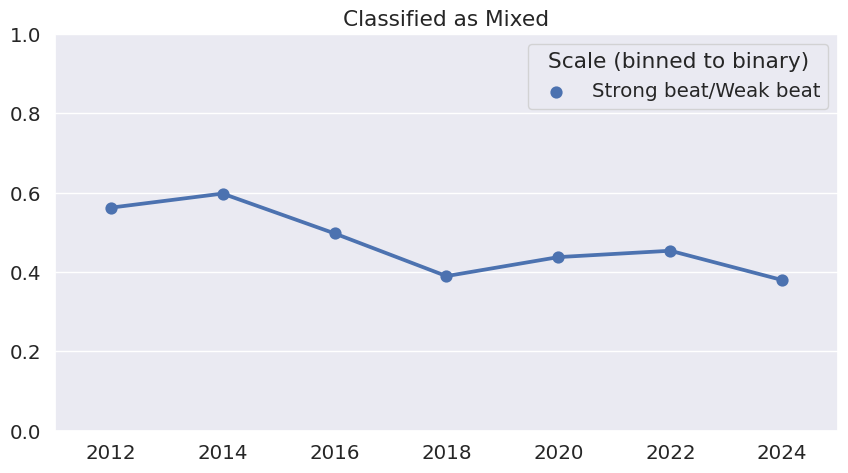

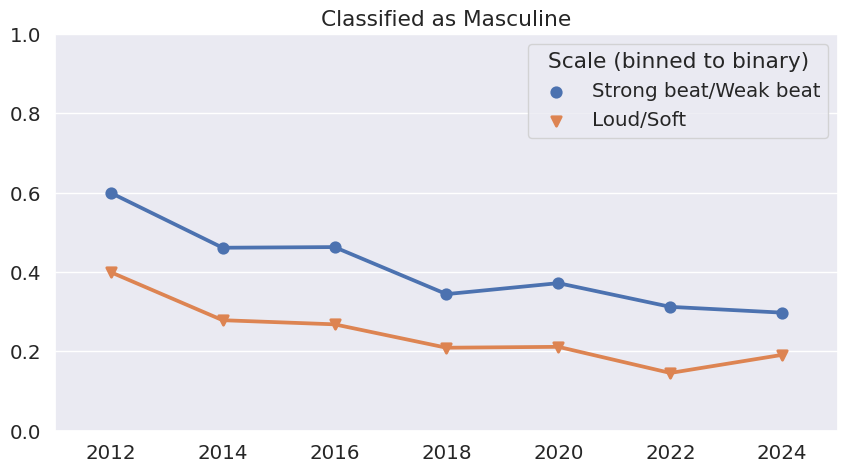

,rho,p,column
target,,,
Masculine,-0.928571,0.002519,Strong beat/Weak beat
Masculine,-0.928571,0.002519,Loud/Soft
Mixed,-0.821429,0.023449,Strong beat/Weak beat


In [22]:
rows = []
for i, target in enumerate(all_targets.unique()):
    temp_corr = []
    target_commercials = all_targets[all_targets==target].index
    target_years = upload_years[target_commercials].copy()
    target_years = target_years.rename(f"Upload year").sort_values()

    target_commercials_df = hybrid_df.loc[target_commercials].copy()
    mid_level_df = target_commercials_df[mid_levels].copy()
    # convert values in mid_level_df to int
    for col in mid_level_df.columns:
        replace_dict = {
            col.split("/")[0]: 0,
            #"undefined": 1,
            col.split("/")[1]: 1 #2
        }
        mid_level_df.loc[:,col] = mid_level_df[col].replace(replace_dict).astype(float)
    temp = mid_level_df.join(target_years).groupby("Upload year").mean()
    
    # drop years with less than minimum_count_per_year commercials
    drop_these_years = target_years.value_counts()[
        target_years.value_counts() < minimum_count_per_year
    ].index.to_list()
    temp = temp[~temp.index.isin(drop_these_years)]

    for column in temp.columns:
        res = spearmanr(temp[column], temp.index)
        rows.append({
            "target": target,
            "rho": res.correlation,
            "p": res.pvalue,
            "column": column
        })
        temp_corr.append(rows[-1])

    temp_corr = pd.DataFrame(temp_corr)
    fields_with_correlation  = temp_corr[(temp_corr.p < 0.05) & (temp_corr.rho.abs() > treshold)]["column"]
    dfm = temp[fields_with_correlation].reset_index().melt(
        "Upload year", 
        var_name='Scale (binned to binary)', 
        value_name="Ratio of positive predictions"
    )

    if fields_with_correlation.to_list():
        plt.figure(figsize=(8.75,5))
        g = sns.pointplot(
            x="Upload year", 
            y="Ratio of positive predictions", 
            hue='Scale (binned to binary)', 
            data=dfm,
            markers=possible_markers[:len(possible_markers)],
            )
        g.set(xlabel=None, ylabel=None, ylim=(0,1))
        g.set_title(f"Classified as {target}")
        plt.tight_layout()
        plt.show()
        #delta = dfm.loc[0]["Ratio of positive predictions"] - dfm.loc[dfm.shape[0]-1]["Ratio of positive predictions"]
        #print(f"Delta: {100*delta:.2f}%")

results_df = pd.DataFrame(rows).set_index("target")
results_df[results_df.p < 0.05].sort_values("p", ascending=True)

#### Theme-wise emotions time-trend analysis

In [23]:
rows = []
for i, theme in enumerate(themes):
    temp_corr = []
    theme_commercials = hybrid_df[hybrid_df[theme]].index
    theme_years = upload_years[theme_commercials].copy()
    theme_years = theme_years.rename(f"Upload year").sort_values()

    theme_commercials_df = hybrid_df.loc[theme_commercials].copy()
    
    emotions_df = theme_commercials_df[emotions]
    # convert values in emotions_df to float
    emotions_df = emotions_df.replace({"low": 0, "high": 1}).astype(float)


    temp = emotions_df.join(theme_years).groupby("Upload year").mean()

    # drop years with less than minimum_count_per_year commercials
    drop_these_years = theme_years.value_counts()[
        theme_years.value_counts() < minimum_count_per_year
    ].index.to_list()
    temp = temp[~temp.index.isin(drop_these_years)]

    for column in temp.columns:
        res = spearmanr(temp[column], temp.index)
        rows.append({
            "theme": theme,
            "rho": res.correlation,
            "p": res.pvalue,
            "column": column
        })
        temp_corr.append(rows[-1])

    temp_corr = pd.DataFrame(temp_corr)
    fields_with_correlation  = temp_corr[(temp_corr.p < 0.05) & (temp_corr.rho.abs() > treshold)]["column"]

    dfm = temp[fields_with_correlation].reset_index().melt(
        "Upload year", 
        var_name='Scale (binned to binary)', 
        value_name="Ratio of positive predictions"
    )

    if fields_with_correlation.to_list():
        plt.figure(figsize=(8.75,5))
        g = sns.pointplot(
            x="Upload year", 
            y="Ratio of positive predictions", 
            hue='Scale (binned to binary)', 
            data=dfm,
            markers=possible_markers[:len(possible_markers)],
            )
        g.set(xlabel=None, ylabel=None, ylim=(0,1))
        g.set_title(f"Classified as {theme}")
        plt.tight_layout()
        plt.show()

results_df = pd.DataFrame(rows)
results_df[results_df.p < 0.05].sort_values("p", ascending=True).set_index("theme")

,rho,p,column
theme,,,


#### Theme-wise mid-level time-trend analysis

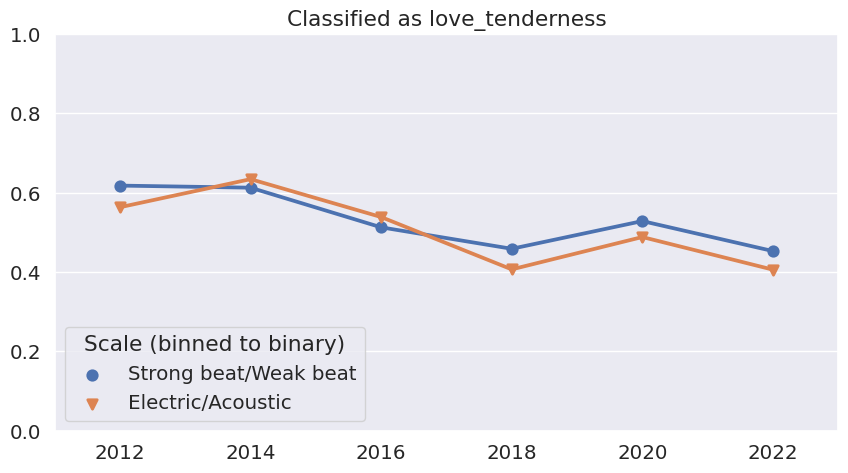

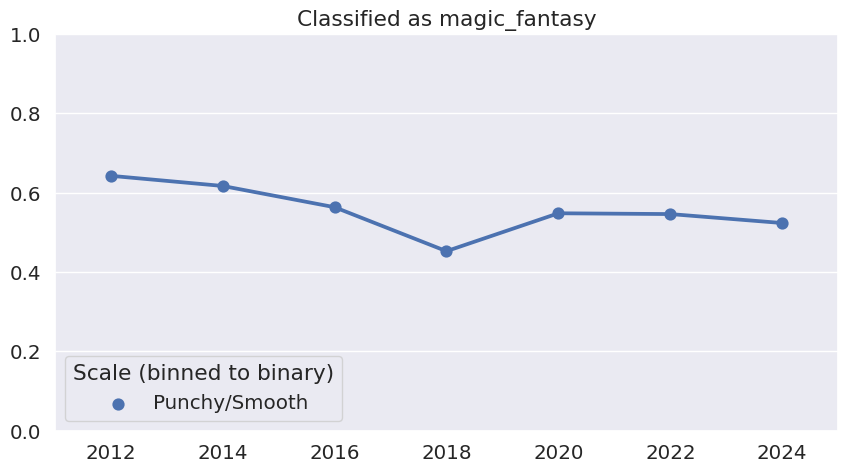

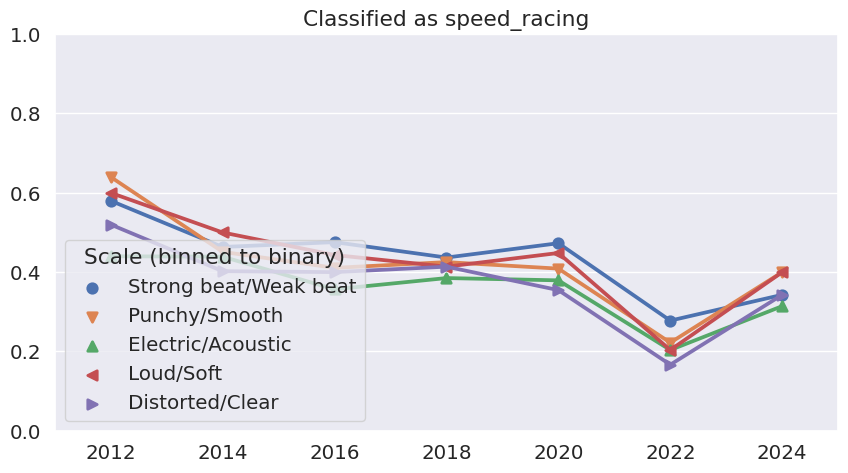

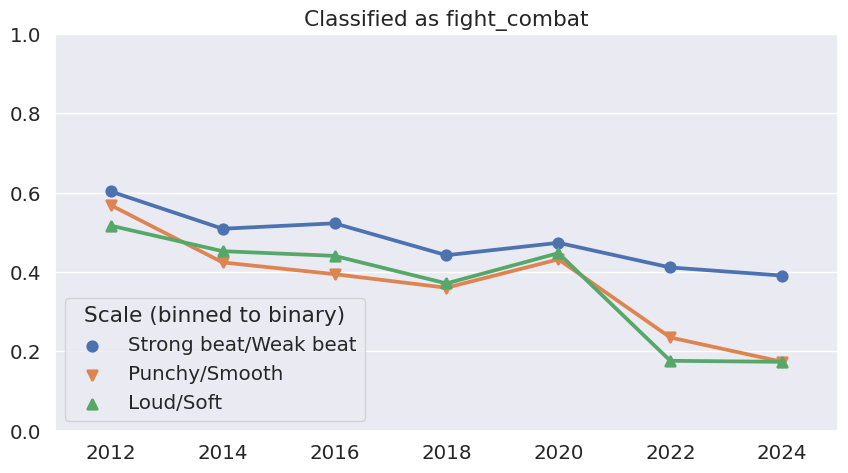

In [24]:
rows = []
for i, theme in enumerate(themes):
    temp_corr = []
    theme_commercials = hybrid_df[hybrid_df[theme]].index
    theme_years = upload_years[theme_commercials].copy()
    theme_years = theme_years.rename(f"Upload year").sort_values()

    theme_commercials_df = hybrid_df.loc[theme_commercials].copy()
    
    mid_level_df = theme_commercials_df[mid_levels].copy()
    # convert values in mid_level_df to int
    for col in mid_level_df.columns:
        replace_dict = {
            col.split("/")[0]: 0,
            #"undefined": 1,
            col.split("/")[1]: 1 #2
        }
        mid_level_df.loc[:,col] = mid_level_df[col].replace(replace_dict).astype(float)
    temp = mid_level_df.join(theme_years).groupby("Upload year").mean()

    #"""
    # drop years with less than minimum_count_per_year commercials
    drop_these_years = theme_years.value_counts()[
        theme_years.value_counts() < minimum_count_per_year
    ].index.to_list()
    #"""
    temp = temp[~temp.index.isin(drop_these_years)]

    for column in temp.columns:
        res = spearmanr(temp[column], temp.index)
        rows.append({
            "theme": theme,
            "rho": res.correlation,
            "p": res.pvalue,
            "column": column
        })
        temp_corr.append(rows[-1])

    temp_corr = pd.DataFrame(temp_corr)
    fields_with_correlation  = temp_corr[(temp_corr.p < 0.05) & (temp_corr.rho.abs() > treshold)]["column"]

    dfm = temp[fields_with_correlation].reset_index().melt(
        "Upload year", 
        var_name='Scale (binned to binary)', 
        value_name="Ratio of positive predictions"
    )

    if fields_with_correlation.to_list():
        plt.figure(figsize=(8.75,5))
        g = sns.pointplot(
            x="Upload year", 
            y="Ratio of positive predictions", 
            hue='Scale (binned to binary)', 
            data=dfm,
            markers=possible_markers[:len(possible_markers)],
            )
        g.set(xlabel=None, ylabel=None, ylim=(0,1))
        g.set_title(f"Classified as {theme}")
        sns.move_legend(g, "lower left")
        plt.tight_layout()
        plt.show()

results_df = pd.DataFrame(rows)

In [25]:
results_df[results_df.p < 0.05].sort_values("theme", ascending=True)

,theme,rho,p,column
56,fight_combat,-0.928571,0.002519,Strong beat/Weak beat
57,fight_combat,-0.785714,0.036238,Punchy/Smooth
59,fight_combat,-0.892857,0.006807,Loud/Soft
20,love_tenderness,-0.828571,0.041563,Strong beat/Weak beat
22,love_tenderness,-0.885714,0.018845,Electric/Acoustic
39,magic_fantasy,-0.785714,0.036238,Punchy/Smooth
47,speed_racing,-0.785714,0.036238,Strong beat/Weak beat
48,speed_racing,-0.928571,0.002519,Punchy/Smooth
49,speed_racing,-0.857143,0.013697,Electric/Acoustic
50,speed_racing,-0.857143,0.013697,Loud/Soft


In [26]:
hybrid_df

,target_of_toy_ad,domesticity_nurturing,fashion_beauty,love_tenderness,nature_animals,magic_fantasy,speed_racing,fight_combat,Happy,Beauty,...,Electric/Acoustic,Loud/Soft,Distorted/Clear,Heavy/Light,Dense/Sparse,transcript,title,description,upload_date,duration
stimulus_id,,,,,,,,,,,,,,,,,,,,,
lldUm6XHTvA,Mixed,False,True,False,False,False,False,False,low,high,...,Electric,Soft,Clear,Light,Sparse,Looking cool on the slopes for some Barbie win...,Barbie Winter Fun Only at Smyths Toys,Check out the brand-new Barbie Winter toys ava...,20221106.0,30.0
6_c5AuYx5t8,Feminine,False,True,True,False,True,False,False,low,high,...,Electric,Loud,Clear,Light,Sparse,We love to squish our Squeez-a-Malls. Squeeze ...,Squeezamals- Smyths Toys,"It's the Squeezamals, the cutest, cuddliest pe...",20180803.0,34.0
U0ZK12Eyrac,Feminine,False,True,False,False,False,False,False,high,high,...,Electric,Loud,Distorted,Heavy,Dense,Barbie! Hey! Airbrush designer You can express...,Smyths Toys - Barbie Airbrush Designer Studio ...,Budding fashion designers will love this Barbi...,20150922.0,20.0
0e2IvWJljOA,Mixed,True,False,False,True,False,False,False,high,high,...,Acoustic,Soft,Clear,Light,Sparse,"Bluey's going on a caravan adventure! Ooh, let...",Bluey's Caravan Adventures - Smyths Toys,Go on a caravan adventure with Bluey's family ...,20220203.0,35.0
hUesoJPchMg,Masculine,False,False,False,False,False,False,True,low,low,...,Electric,Loud,Distorted,Heavy,Dense,"I've got a tricky mission. It's okay, we have ...",Smyths Toys - Nerf Blasters,Have you got a tricky mission? It's Nerf or no...,20170719.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SFDQWY3IQ6A,Mixed,True,True,True,True,True,True,True,low,low,...,Electric,Loud,Distorted,Heavy,Dense,"For the first time ever, the Jenga Tower is o...",Smyths Toys - Jenga Pass Challenge,Take the classic Jenga game ‘off the table’ wi...,20180220.0,NaN
-o98tc5dDUI,Mixed,True,True,True,True,True,True,True,high,high,...,Acoustic,Loud,Clear,Light,Dense,"Robo Chameleon. Move, aim, and catch. Meet th...",Robo Chameleon- Smyths Toys,Robo Chameleon is a perfect companion! This gr...,20180621.0,NaN
LZm_wAgLSFE,Feminine,True,True,True,True,True,True,True,high,high,...,Electric,Soft,Distorted,Heavy,Dense,Bath Bomb Factory. Set up your own lab to mol...,Wild Science Bath Bomb Factory - Smyths Toys,Create your own fizzy bath bombs with the Wild...,20210409.0,NaN


### Interactions between themes and scales

In [27]:
numerical_hybrid_df = hybrid_df.copy()
numerical_hybrid_df[emotions] = numerical_hybrid_df[emotions].replace({"low": 0, "high": 1}).astype(float)

mid_level_df = numerical_hybrid_df[mid_levels].copy()
# convert values in mid_level_df to int
for col in mid_level_df.columns:
    replace_dict = {
        col.split("/")[0]: 0,
        #"undefined": 1,
        col.split("/")[1]: 1 #2
    }
    mid_level_df.loc[:,col] = mid_level_df[col].replace(replace_dict).astype(float)

numerical_hybrid_df[mid_levels] = mid_level_df

In [28]:
rows = []
for scale in emotions + mid_levels:
    # count, for each theme, how many commercials are classified as high
    #print(f"Emotion: {scale}")
    counts = numerical_hybrid_df[numerical_hybrid_df[scale]==1][themes].sum().to_dict()

    # normalize counts by the total number of commercials in that theme
    total_counts = numerical_hybrid_df[themes].sum().to_dict()
    normalized_counts = {theme: round(v / total_counts[theme],2) for theme, v in counts.items() if total_counts[theme] > 0}

    # sort the normalized counts
    sorted_counts = dict(sorted(normalized_counts.items(), key=lambda item: item[1], reverse=True))
    #print(sorted_counts)
    rows.append(normalized_counts)
    """
    for theme, count in sorted_counts.items():
        print(f"{theme}: {count:.2f}")
    print("\n")
    """
    

In [29]:
heatmap_df = pd.DataFrame(rows, index=emotions + shortened_mid_levels)
heatmap_df.columns = themes_shortened

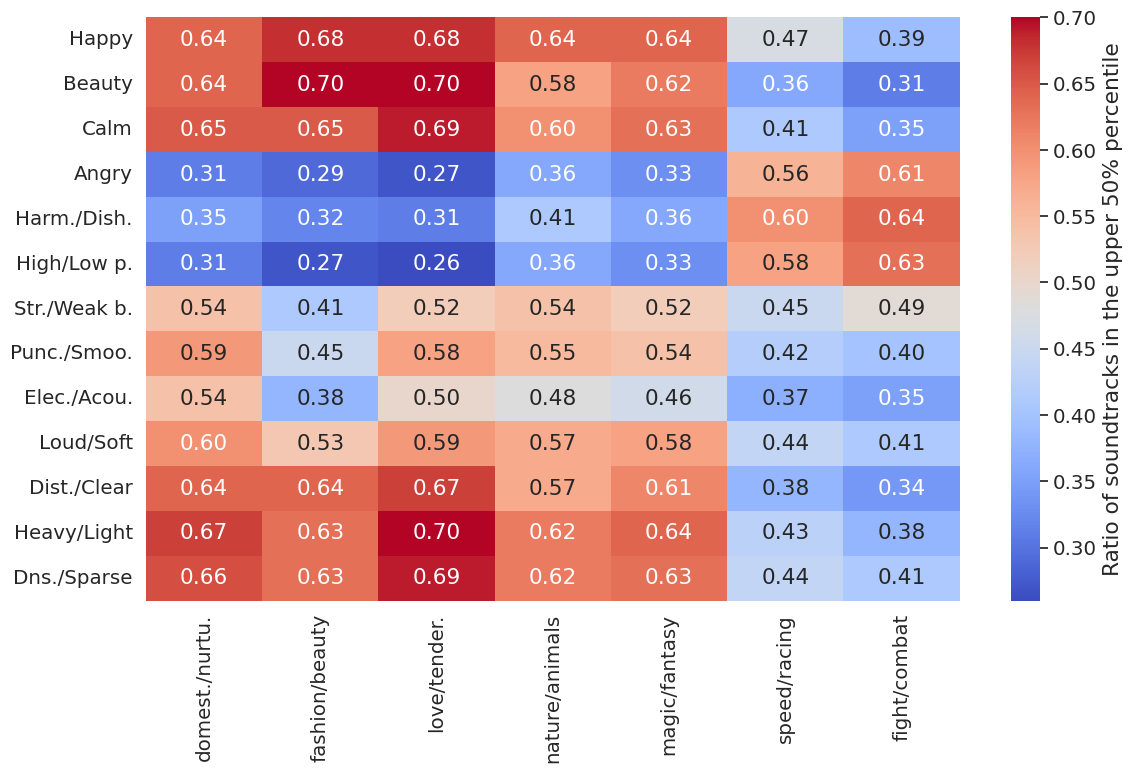

In [30]:
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Ratio of soundtracks in the upper 50% percentile'})
#plt.title("Predominance of emotions and mid-levels by theme")
plt.savefig("heatmap.pdf", bbox_inches="tight")
plt.tight_layout()